## 후진 제거법
: 모든 독립변수를 고려한 모델에서 유의하지 않는 독립변수를 하나씩 제거하는 방법

### 1. 데이터셋 불러오기 (Wine)

In [27]:
from sklearn import datasets
import pandas as pd
wine = datasets.load_wine()
X, y = wine['data'], wine['target']

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.3,
                                                   random_state=0,
                                                   stratify=y)

In [29]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### 2. SBS 알고리즘 

In [31]:
from sklearn.base import clone 
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# warining 무시
import warnings
warnings.filterwarnings('ignore')

In [9]:
class SBS():
    def __init__(self, estimator, k_features,
                scoring=accuracy_score,
                test_size=0.25, random_state=1):
        self.scoring  = scoring # 모델 성능 평가용
        self.estimator = clone(estimator) # 테스트할 모델
        self.k_features = k_features # 목표하는 특정 개수 
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                                                           random_state = self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                '''원하는 개수까지 축소하며 생성된 모든 특성 조합 평가'''
                score = self._calc_score(X_train, y_train,
                                        X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best] # index 활용하여 score 높은 조합 저장
            self.subsets_.append(self.indices_) # 총괄 subsets_에 저장
            dim -= 1 # 조합 개수 하나씩 줄이기
            self.scores_.append(scores[best])# index 활용하여 score 높은 거 저장
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self,X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, 
                   indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:,indices])
        score = self.scoring(y_test, y_pred)
        return score

### 3. 성능 평가

In [ ]:
## KNN분류기로 SBS 구현이 잘 작동하는지 확인
'''후진 제거법을 적용해, 크기가 작아진 데이터셋에서도 성능이 크게 떨어지지 않음'''

In [10]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)

In [12]:
sbs = SBS(knn, k_features=1)

In [32]:
sbs.fit(X_train_std, y_train)

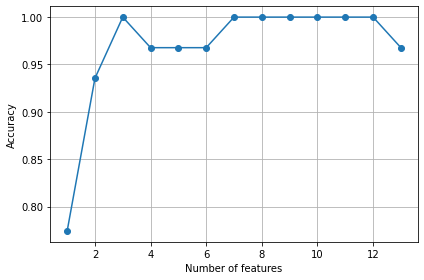

In [36]:
'''각 단계에서 가장 좋은 특성 조합의 점수 plot'''

k_feat = [len(k) for k in sbs.subsets_] # 부분집합의 길이

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show() # k=3

In [37]:
'''가장 작은 개수의 조합(k=3)에서 높은 성능을 내는 특성 확인'''
k3 = list(sbs.subsets_[10]) # 3개의 컬럼 저장
print(df_wine.columns[1:][k3])

Index(['malic_acid', 'ash', 'proline'], dtype='object')


In [42]:
'''테스트 세트에서의 KNN 분류기 성능 평가'''
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))

훈련 정확도: 0.967741935483871
테스트 정확도: 0.9629629629629629


In [43]:
'''선택된 3개의 특성에서 KNN 성능 확인'''
knn.fit(X_train_std[:, k3], y_train)
print('훈련 정확도:', knn.score(X_train_std[:,k3], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k3], y_test))

훈련 정확도: 0.9516129032258065
테스트 정확도: 0.9259259259259259
